In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 4})

In [2]:
# We shall use the most recent model years, which at the moment is 1056 to 1060
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.1056-1060.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.1056-1060.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.1056-1060.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.1056-1060.so.nc'
datadir05 = 'ocean_annual_z/ts/annual/5yr/'
filename_temp05 = 'ocean_annual_z.1056-1060.thetao.nc'

In [3]:
age = xr.open_dataset(rootdir + datadir + filename_age) # Ideal Age
temp = xr.open_dataset(rootdir + datadir + filename_temp) # Temperature
vol = xr.open_dataset(rootdir + datadir + filename_vol) #Volume
so = xr.open_dataset(rootdir + datadir + filename_so) #Salinity
temp05 = xr.open_dataset(rootdir + datadir05 +filename_temp05) # Temp but in 0.5 degrees

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


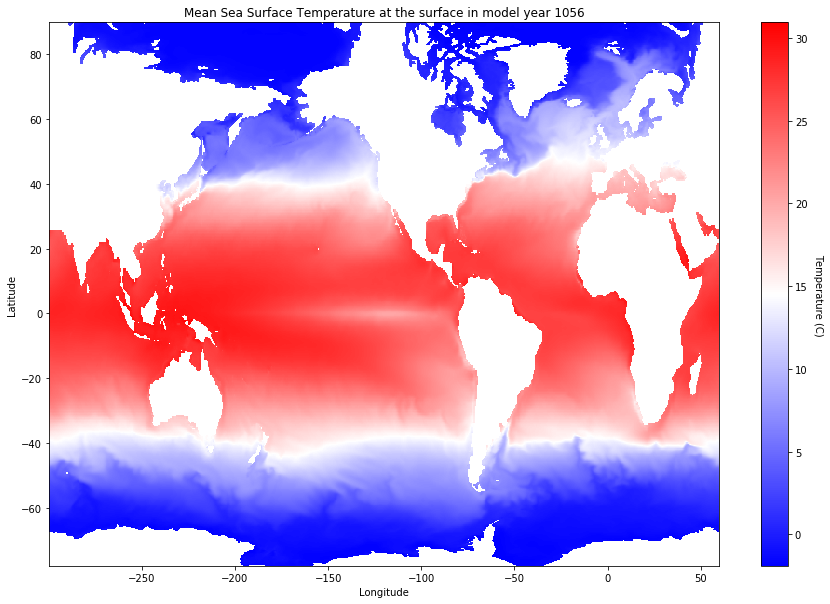

In [4]:
# plot the temperature one first to show ESM4! 
plt.figure(figsize = (15,10)) #Changes the size of the figure, larger map makes it easier to see data
im = plt.pcolormesh(temp05.xh, temp05.yh, temp05.thetao.isel(time = 0, z_l =0), cmap = cm.bwr) 
cbar = plt.colorbar(im)
plt.title('Mean Sea Surface Temperature at the surface in model year 1056')
cbar.set_label('Temperature (C)', rotation =270, labelpad=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
def calc_sigmantr(T,S):
    '''function sigmantr = calc_sigmantr(T,S)
    CALCULATE APPROXIMATE NEUTRAL DENSITY FROM POTENTIAL TEMPERATURE AND SALINITY,
    using functional form of MacDougall and Jackett (2005)
    
    INPUT
        T    potential temperature in degrees celsius
        S    salinity in psu

    OUTPUT
        sigmantr    approximation of neutral density from empirical formula of MacDougall and Jackett (2005)

    Copied across from cdfsigntr.f90 from CDFTOOLS package by G.MacGilchrist (gmacgilchrist@gmail.com)'''
    
    dl_t = T;
    dl_s = S;
    dl_sr= np.sqrt(np.abs(dl_s));

    ### Numerator
    # T-polynome
    dl_r1=((-4.3159255086706703e-4*dl_t+8.1157118782170051e-2 )*dl_t+2.2280832068441331e-1 )*dl_t+1002.3063688892480e0;
    # S-T Polynome
    dl_r2=(-1.7052298331414675e-7*dl_s-3.1710675488863952e-3*dl_t-1.0304537539692924e-4)*dl_s;
    ### Denominator
    # T-Polynome
    dl_r3=(((-2.3850178558212048e-9*dl_t-1.6212552470310961e-7)*dl_t+7.8717799560577725e-5)*dl_t+4.3907692647825900e-5)*dl_t+1.0e0;
    # S-T Polynome
    dl_r4=((-2.2744455733317707e-9*dl_t*dl_t+6.0399864718597388e-6)*dl_t-5.1268124398160734e-4 )*dl_s;
    # S-T Polynome
    dl_r5=(-1.3409379420216683e-9*dl_t*dl_t-3.6138532339703262e-5)*dl_s*dl_sr;

    # Neutral density
    sigmantr = ( dl_r1 + dl_r2 ) / ( dl_r3 + dl_r4 + dl_r5 ) - 1000E0;
    
    return sigmantr

In [6]:
# Calculate Neutral Density
neutralden = calc_sigmantr(temp.thetao, so.so)
neutralden.name = 'neutral_density'
# Calculate Potential Density
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'potential_density'

In [7]:
ds = xr.merge([temp, age, vol, so, neutralden, pot_den])

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

In [8]:
def weightedstd(ds,variable,weights):
    # variable and weights are strings
    M = ds[variable].size
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    numerator = ds[weights]*(ds[variable]-weightedmean)**2
    numerator = numerator.sum()
    denominator = ((M-1)/M)*ds[weights].sum()
    weightedstd = numerator/denominator
    return weightedstd**(0.5)
def weightedmean(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    return weightedmean

In [9]:
def calculate(dataset, sort, bins, bin_label, var, w, bol):
    # dataset => dataset you use, sort => what are you grouping with, var => variable, w= weight, 
    # bol = a boolean, true = want weighted mean, false want weighted std)
    newdataset = dataset.groupby_bins(sort, bins, labels=bin_label)
    mean = newdataset.apply(weightedmean, variable = var, weights = w)
    wstd = newdataset.apply(weightedstd, variable = var, weights= w)
    if (bol == True):
        return mean
    else: 
        return wstd

In [10]:
def binplots(x, y, error, labely, labelx, year):
    plt.figure(figsize = (15,10))
    plt.errorbar(x, y, xerr = error, marker = 'o', linestyle = '--', markeredgecolor = 'r')
    plt.title( labelx + ' with respect to ' + labely + ' for years '  + str(year) + ' to ' + str(year +4) )
    plt.gca().invert_yaxis() # Flips y axis, since depth of 0 is the ocean surface, but for comparison purposes we will not do that
    plt.ylabel(labely)
    plt.xlabel(labelx)
    plt.show()

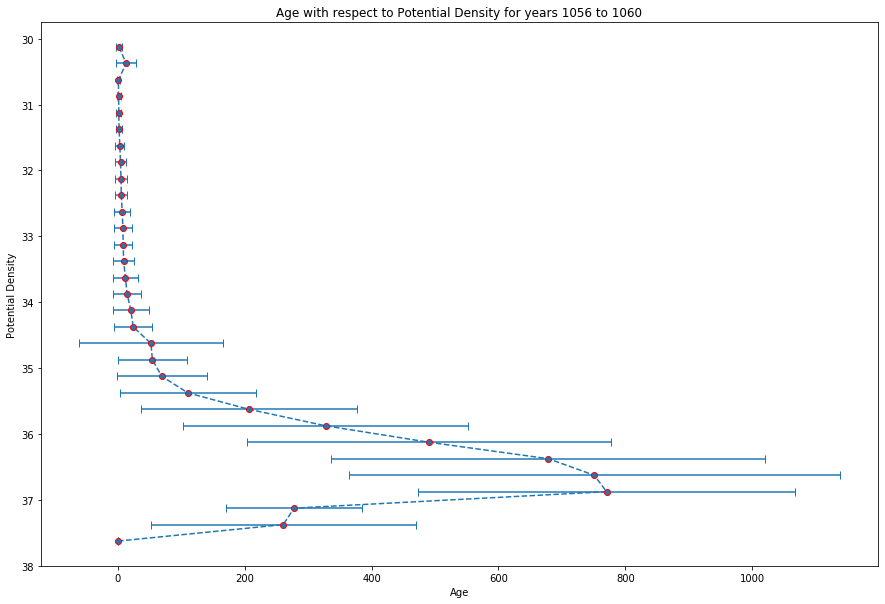

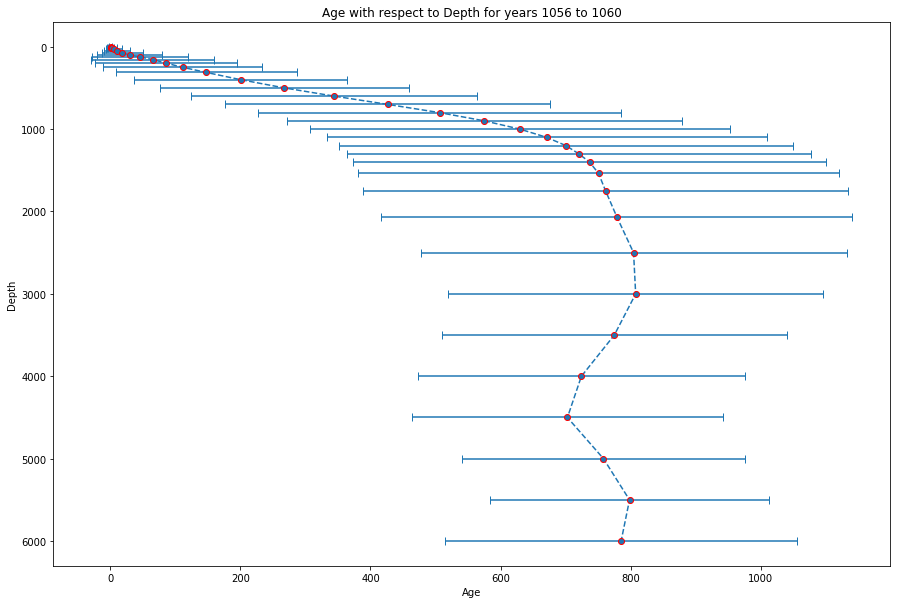

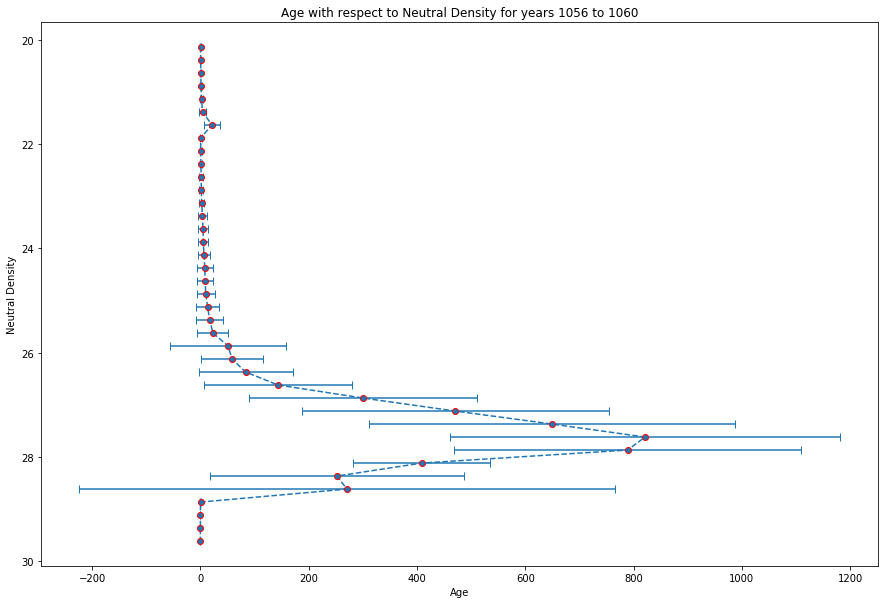

In [11]:
# Potential Density Bins
potden_bins = np.arange(30, 38, 0.25)
potden_bins_labels = np.arange(30.125,37.875, 0.25)
# Depth Bins
z_l = so.z_l
z_small = z_l[:34]
# Neutral Density Bins
neutralden_bins = np.arange(20, 30, 0.25)
neutralden_bins_labels = np.arange(20.125, 29.875, 0.25)
# Calculate weighted mean and standard deviation
# For potential Density
den_mean = calculate(ds, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', True)
den_wstd = calculate(ds, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', False)
# For Depth
dep_mean = calculate(ds, 'z_l', z_l, z_small, 'agessc', 'volcello', True)
dep_wstd = calculate(ds, 'z_l', z_l, z_small, 'agessc', 'volcello', False)
# For Neutral Density
nden_mean = calculate(ds, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', True)
nden_wstd = calculate(ds, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', False)
# Plot mean and standard deviation 
# for Potential Density
binplots(den_mean, potden_bins_labels, den_wstd, 'Potential Density', 'Age', 1056)
# For Depth
binplots(dep_mean, z_small, dep_wstd, 'Depth', 'Age', 1056)
# For Neutral Density
binplots(nden_mean, neutralden_bins_labels, nden_wstd, 'Neutral Density', 'Age', 1056)

In [12]:
# here are some plots of depth with respect to potential and neutral density. 
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature

plottingpotden = np.asarray(ds.potential_density[0])
plotneutralden = np.asarray(ds.neutral_density[0])
volle = np.asarray(ds.volcello[0])
deptharray = np.array(ds.z_l)
def depthplots(density, volume, depth, val, val2, property):
    depthplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = density[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a > val):
                    depthplot[j][k] += depth[i]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = depthplot/volplot
    hold = xr.DataArray(refplot, coords= [lat, lon], dims = ['lat', 'lon'])
    hold.name = 'Mean Depth (meters)'
    plt.figure(figsize = (15,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0,globe=None)) # Define your map projection
    ax.coastlines() # Add coastline
    ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor = 'grey') # fill in continents with color grey
    im = hold.plot(ax= ax, transform = ccrs.PlateCarree()) # plot the dataarray with projection.
    # cbar.set_label('Depth (meters)', rotation = 270, labelpad=16)
    gridlines = ax.gridlines(draw_labels=True)
    plt.title('Average depth of '+ property + ' contours between ' + str(val) + ' and ' + str(val2) + ' in year 1056', y =1.05)
    ax.text(-0.04, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
    ax.text(0.5,-0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
    plt.show()

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


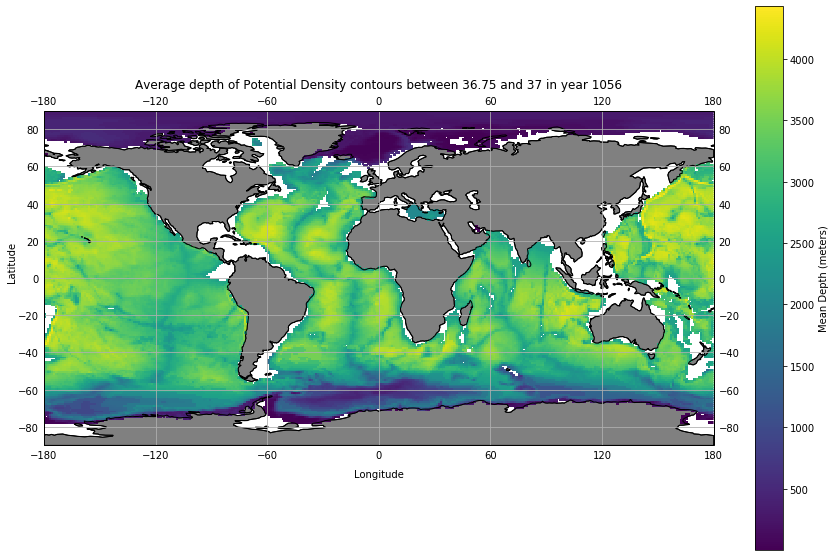

In [13]:
depthplots(plottingpotden, volle, deptharray, 36.75, 37, 'Potential Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


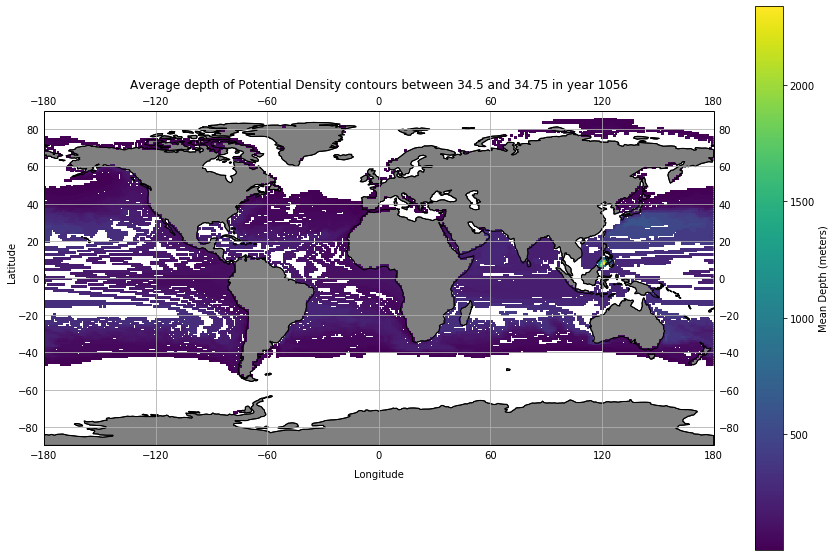

In [14]:
depthplots(plottingpotden, volle, deptharray, 34.5, 34.75, 'Potential Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


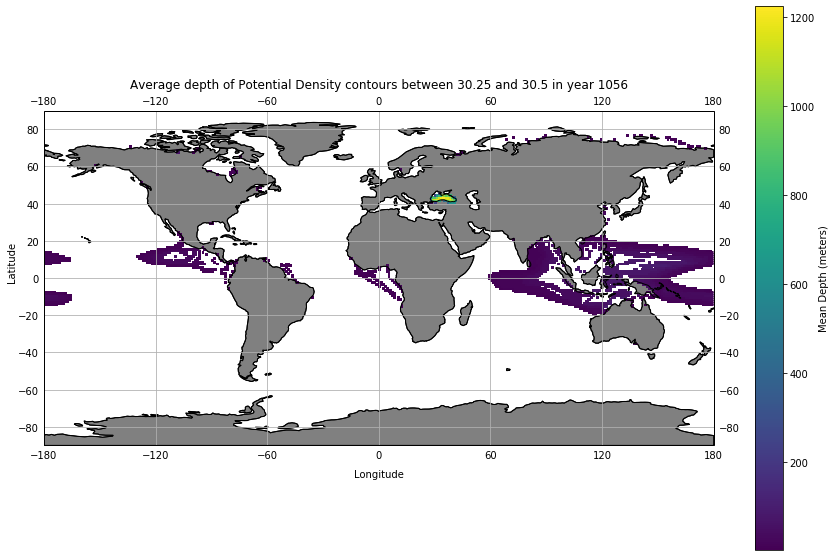

In [15]:
depthplots(plottingpotden, volle, deptharray, 30.25, 30.5, 'Potential Density')

In [16]:
def ageplots(density, volume, age, val, val2, property):
    ageplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = density[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a >= val):
                    ageplot[j][k] += age[i][j][k]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = ageplot/volplot
    hold = xr.DataArray(refplot, coords= [lat, lon], dims = ['lat', 'lon'])
    hold.name = 'Ideal Age (years)'
    plt.figure(figsize = (15,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0,globe=None)) # Define your map projection
    ax.coastlines() # Add coastline
    ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor = 'grey') # fill in continents with color grey
    im = hold.plot(ax= ax, transform = ccrs.PlateCarree()) # plot the dataarray with projection.
    # cbar.set_label('Depth (meters)', rotation = 270, labelpad=16)
    gridlines = ax.gridlines(draw_labels=True)
    plt.title('Average Ideal Age of '+ property + ' contours between ' + str(val) + ' and ' + str(val2) + ' in year 1056', y =1.05)
    ax.text(-0.04, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
    ax.text(0.5,-0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
    plt.show()

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


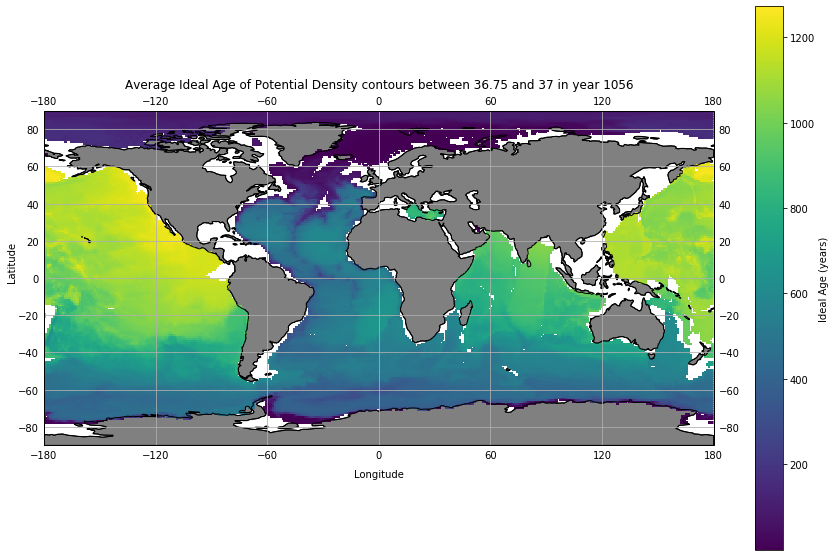

In [17]:
ageplots(plottingpotden, volle, np.asarray(ds.agessc.isel(time=0)), 36.75, 37, 'Potential Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


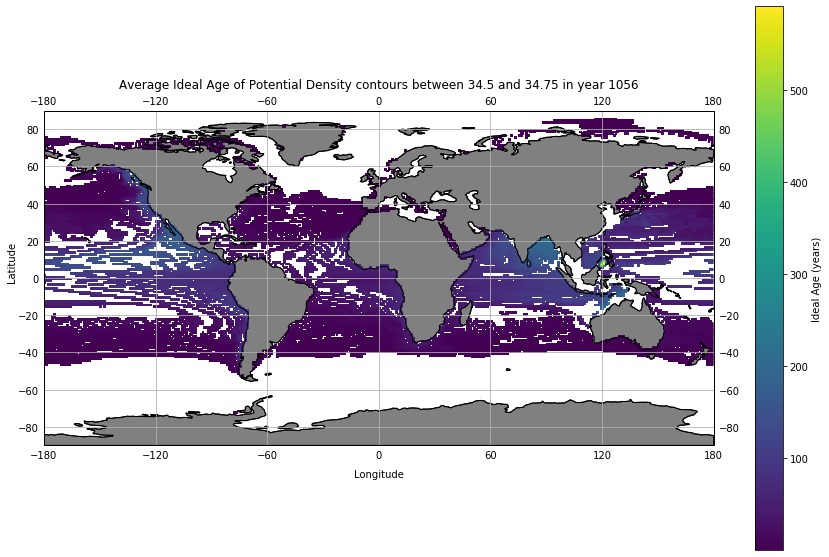

In [18]:
ageplots(plottingpotden, volle, np.asarray(ds.agessc.isel(time=0)), 34.5, 34.75, 'Potential Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


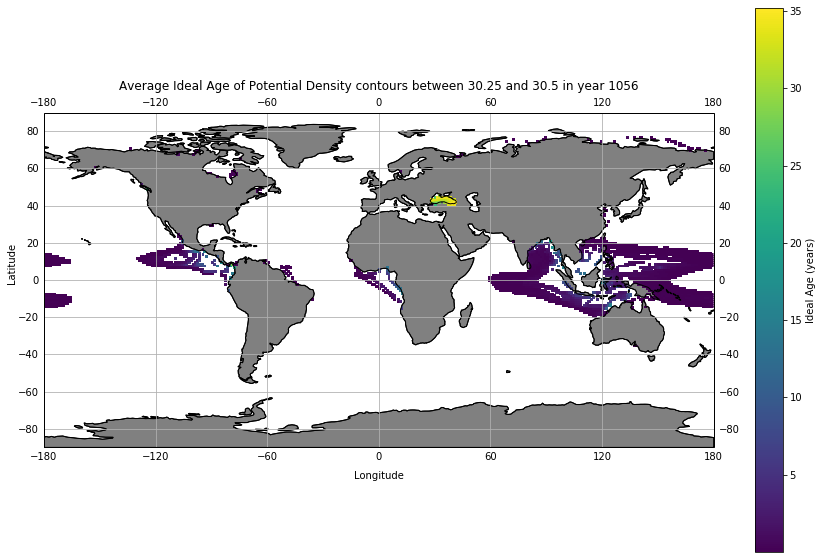

In [19]:
ageplots(plottingpotden, volle, np.asarray(ds.agessc.isel(time=0)), 30.25, 30.50, 'Potential Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


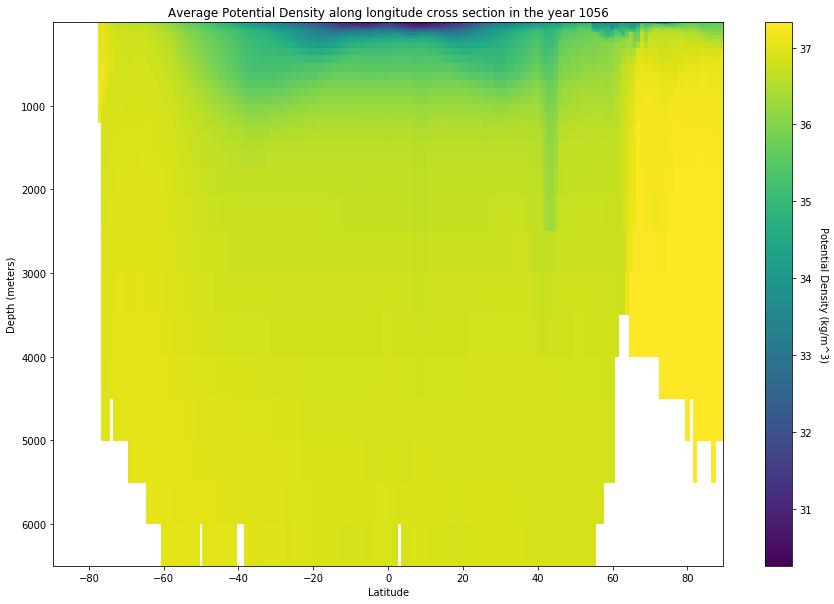

In [20]:
age_average = age.agessc.mean('lon')
density_average = ds.potential_density.mean('lon')
plt.figure(figsize = (15,10))
a = plt.pcolormesh(ds.lat, ds.z_l, density_average[0])
cbar = plt.colorbar(a)
cbar.set_label('Potential Density (kg/m^3)', rotation =270, labelpad=16)
plt.gca().invert_yaxis()

plt.title('Average Potential Density along longitude cross section in the year 1056')
plt.xlabel('Latitude')
plt.ylabel('Depth (meters)')
plt.show()

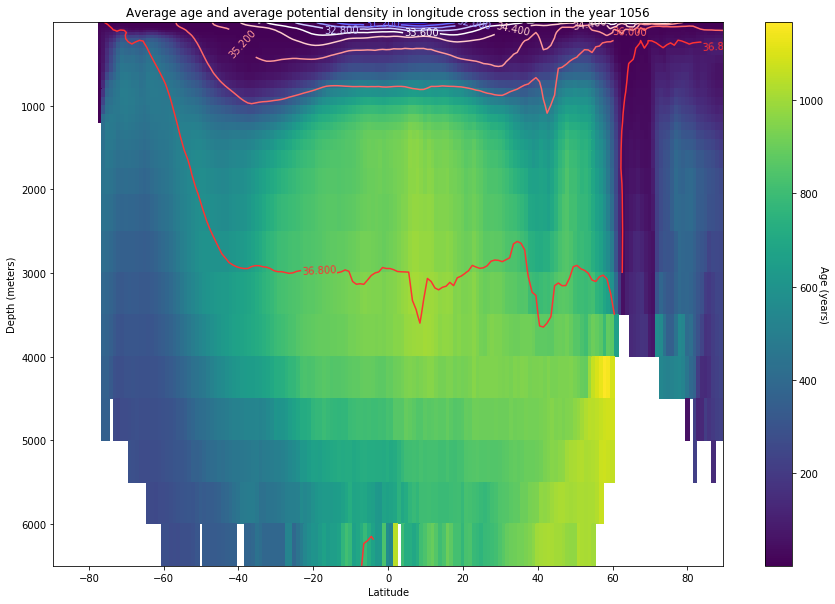

In [21]:
plt.figure(figsize = (15,10))
im = plt.pcolormesh(lat, z_l, age_average[0])
a = plt.contour(lat, z_l, density_average[0], 10, cmap = plt.cm.bwr)
plt.clabel(a, inline = 1, fontsize = 10)
cbar = plt.colorbar(im)
cbar.set_label('Age (years)', rotation = 270)
plt.gca().invert_yaxis()
plt.title('Average age and average potential density in longitude cross section in the year 1056')
plt.xlabel('Latitude')
plt.ylabel('Depth (meters)')
plt.show()

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


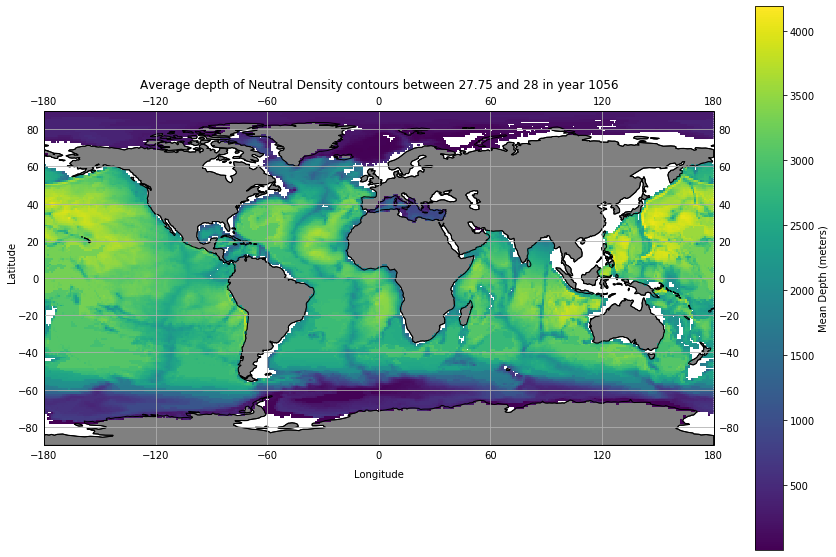

In [23]:
# The next step is to do this with neutral density! Continue with this part using neutral density! 
depthplots(plotneutralden, volle, deptharray, 27.75, 28, 'Neutral Density')


/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


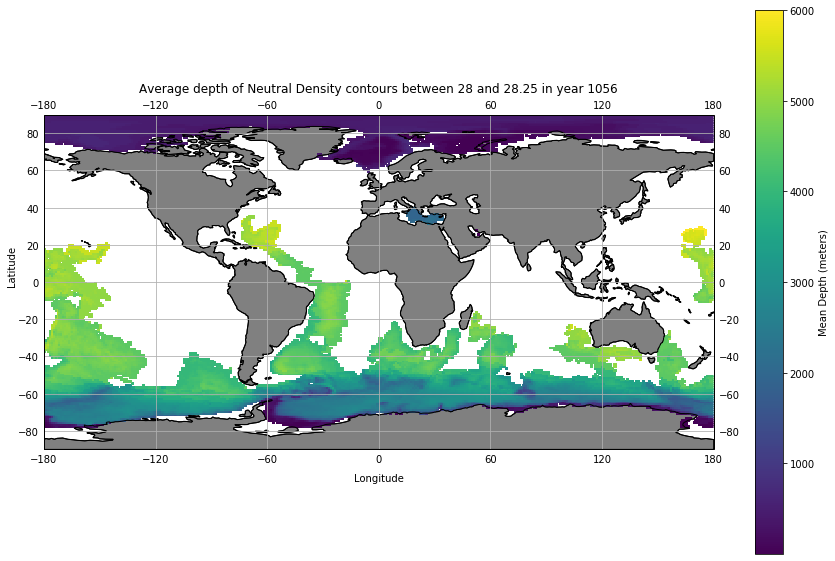

In [24]:
depthplots(plotneutralden, volle, deptharray, 28, 28.25, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


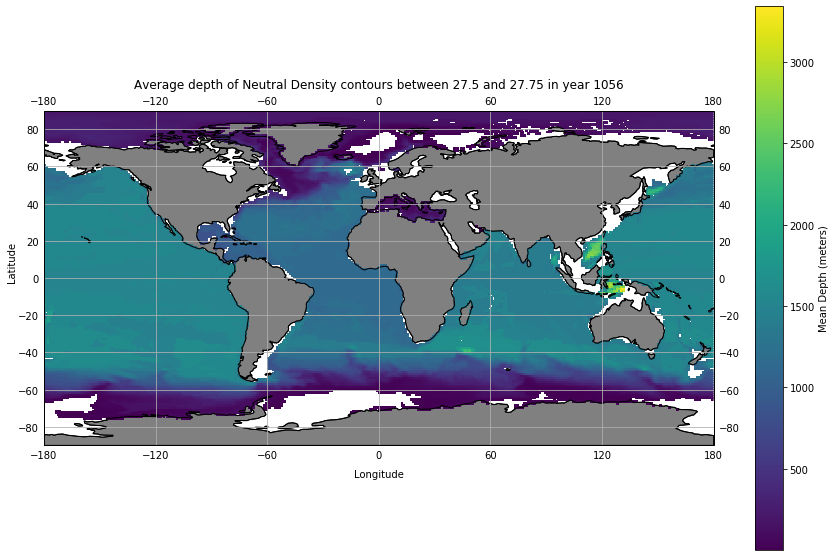

In [25]:
depthplots(plotneutralden, volle, deptharray, 27.5, 27.75, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


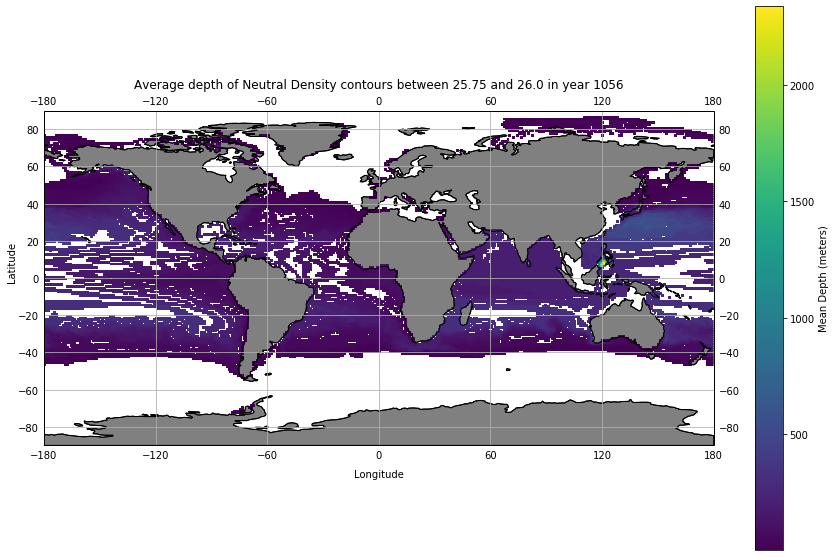

In [26]:
depthplots(plotneutralden, volle, deptharray, 25.75, 26.0, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


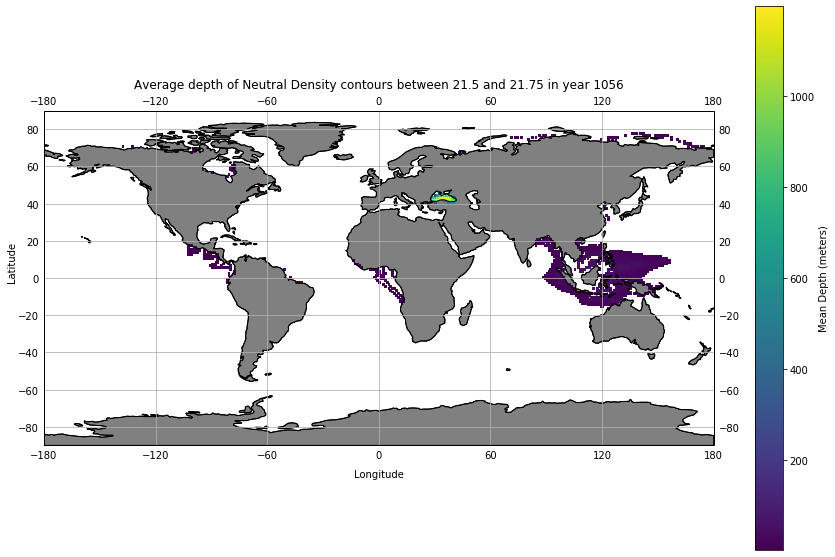

In [27]:
depthplots(plotneutralden, volle, deptharray, 21.5, 21.75, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


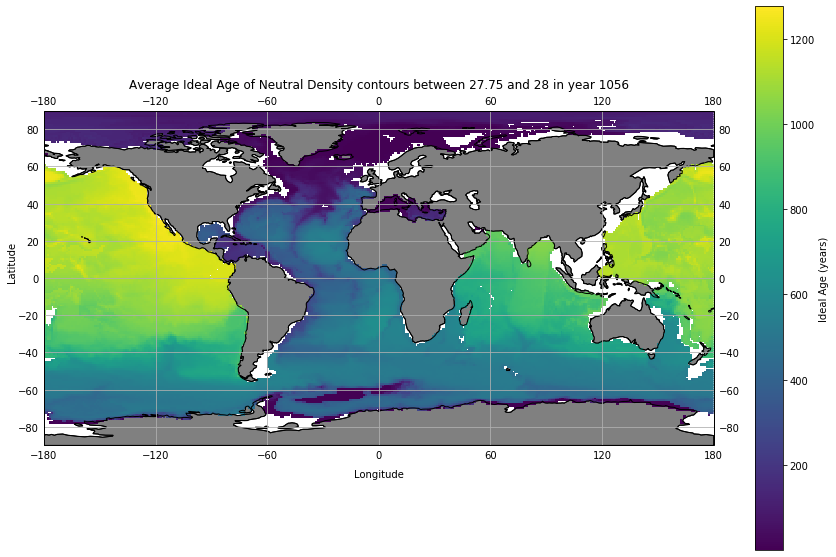

In [28]:
ageplots(plotneutralden, volle, np.asarray(ds.agessc.isel(time=0)), 27.75, 28, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


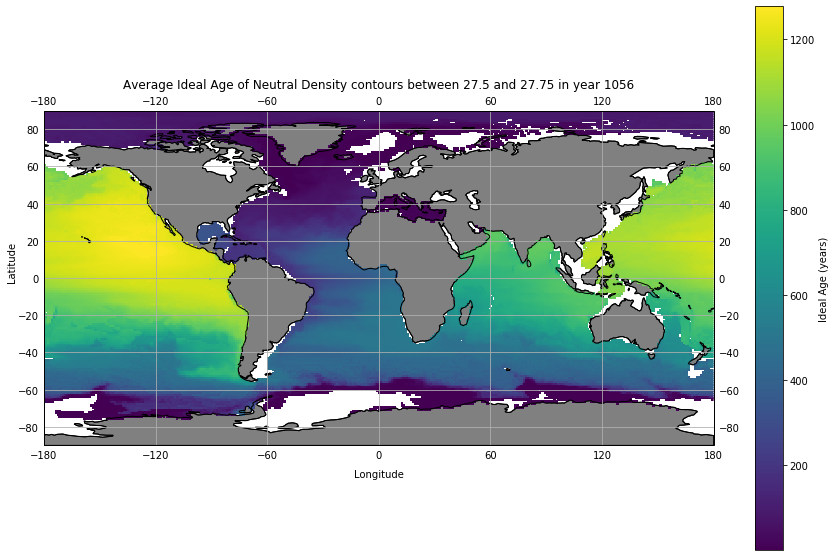

In [29]:
ageplots(plotneutralden, volle, np.asarray(ds.agessc.isel(time=0)), 27.5, 27.75, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


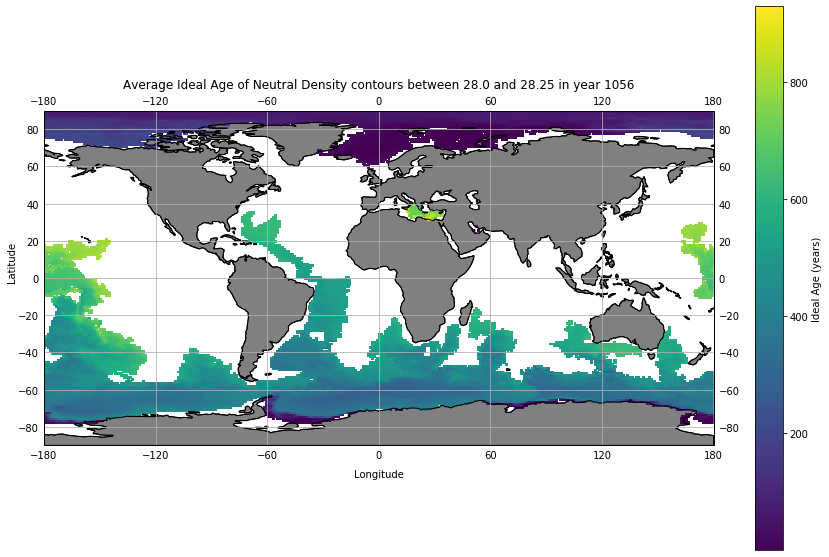

In [30]:
ageplots(plotneutralden, volle, np.asarray(ds.agessc.isel(time=0)), 28.0, 28.25, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


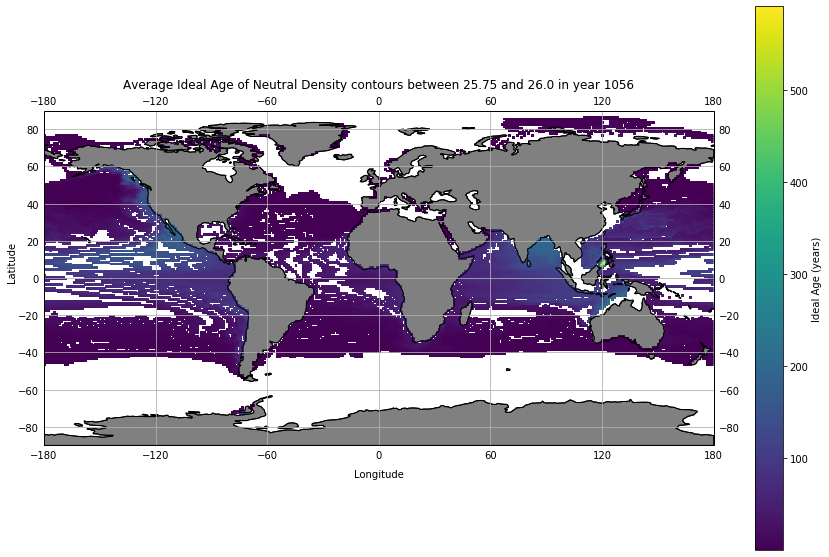

In [31]:
ageplots(plotneutralden, volle, np.asarray(ds.agessc.isel(time=0)), 25.75, 26.0, 'Neutral Density')

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


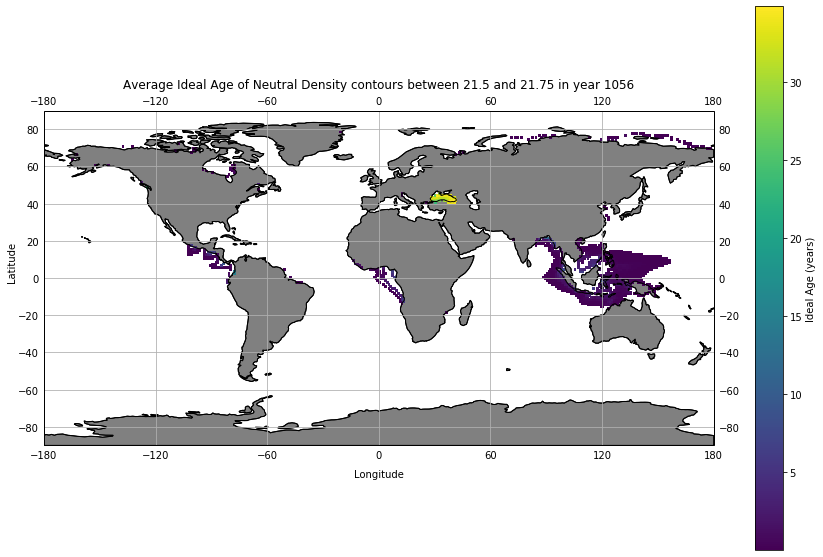

In [32]:
ageplots(plotneutralden, volle, np.asarray(ds.agessc.isel(time=0)), 21.5, 21.75, 'Neutral Density')